In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
%matplotlib inline

# Analyzing Relationship Between Limit Order Book Imbalance and Returns - High Frequency Signal
---

## Contents

0. [Introduction](#intro)
1. [DataFrame Setup](#sec1)
2. [Summary Statistics and Figures](#sec2)
3. [Relationship between VOI and Returns](#sec3)
4. [Trading Signal / Strategy](#sec4)
5. [Conclusion](#conc)
---

<a id='intro'></a>
## `Introduction`
---

##### `Tick By Tick` Data
In `High Frequency Trading` (HFT), a crucial data source is `Tick By Tick` (TBT) data. We will work with the `Lobster TBT` data for this analysis. In particular we will use [Level 5](https://lobsterdata.com/info/DataSamples.php) data for [Microsoft](https://en.wikipedia.org/wiki/Microsoft) (NASDAQ: **`MSFT`**). 

There are $2$ [files](https://lobsterdata.com/info/DataStructure.php) (*use the link to understand more about the structure of both the files*):

- **`Message File`** -  The message file contains all the “events” that happen in live markets: new order addition, modification, deletion and trades(execution) and also contains price and size for those events.
- **`Order Book File`** - The order book file contains the information (**price** and **volume / size**) about orders at various levels (levels $1$ to $5$ for our dataset), this information corresponds line by line to the message file. Level 1 is referred to as **best bid / ask** depending on the side(buy or sell) of the orderbook.

For our analysis, we will only use the “trades” data within this TBT data, i.e, we will only consider rows in the message files marked as trades (executions). Note that hidden order executions (event type $5$ have order ID = $0$)

---

##### `Volume Order Imbalance` (VOI)
We define `volume order imbalance` (VOI) at the top level of order book as: 
$$
VOI = \frac{(V_{b}-V_{a})}{(V_{b}+V_{a})}
$$
where $V_a$ is the best ask volume and $V_b$ is the best bid volume. 

Also, the `Bid-Ask spread` is defined as:
$$
Spread = Best Ask Price - Best Bid Price
$$

<a id='sec1'></a>
## 1. `DataFrame Setup`
---
In this section we will read our `message` and `order book` **csv** files as a **_`pandas`_ DataFrame** and set it up for our analysis.

We do the following $-$ 
- Read the csv file into multiple DataFrame
- Clean the DataFrame
- Get the relevant columns - `VOI`, `Price`, `Returns`, `Bid Ask Spread` etc.
- See summary statistics and plots

In [2]:
date = '20120621'    ## YYYYMMDD
ticker = 'MSFT'

##### Read `message` file into `MSFT_msg_df` DataFrame

In [3]:
MSFT_msg_df = pd.read_csv(f'/Users/shubhamrathi/Desktop/iRage/{ticker}_msg_5.csv',
                          header = None,
                          index_col = 0)

MSFT_msg_df.index = pd.to_timedelta(MSFT_msg_df.index, unit = 's') + pd.Timestamp(date)    # fix index time unit
MSFT_msg_df.index.name = 'Time'                                                            # index name
MSFT_msg_df.columns = ['Event Type', 'Order ID', 'Size', 'Price', 'Direction']             # column names
MSFT_msg_df['Price'] /= 10**4                                                              # fix price units

MSFT_msg_df

,Event Type,Order ID,Size,Price,Direction
Time,,,,,
2012-06-21 09:30:00.013994120,3,16085616,100,31.040,-1
2012-06-21 09:30:00.013994120,1,16116348,100,31.050,-1
2012-06-21 09:30:00.015247805,1,16116658,100,31.040,-1
2012-06-21 09:30:00.015442111,1,16116704,100,31.050,-1
2012-06-21 09:30:00.015789148,1,16116752,100,31.060,-1
...,...,...,...,...,...
2012-06-21 15:59:59.861465727,3,287081309,9249,30.140,-1
2012-06-21 15:59:59.861566671,3,287117122,783,30.140,-1
2012-06-21 15:59:59.873177404,3,287070525,800,30.150,-1


##### Filter out trades (i.e. `Event Type` = $4$ and $5$) into `MSFT_msg_trades_df` DataFrame
Because we will only work with trades data (events that change `Price` and `Bid / ask size`)

In [4]:
mask_trades_MSFT = (MSFT_msg_df['Event Type'] == 4) | (MSFT_msg_df['Event Type'] == 5)    # boolean filter
MSFT_msg_trades_df = MSFT_msg_df.loc[mask_trades_MSFT]
MSFT_msg_trades_df

,Event Type,Order ID,Size,Price,Direction
Time,,,,,
2012-06-21 09:30:00.039883970,5,0,300,30.960,-1
2012-06-21 09:30:00.039883970,5,0,27,30.970,-1
2012-06-21 09:30:00.317289601,4,16168549,100,30.970,-1
2012-06-21 09:30:00.317289601,4,16166187,100,30.970,-1
2012-06-21 09:30:00.317289601,4,16167006,100,30.970,-1
...,...,...,...,...,...
2012-06-21 15:59:59.205348926,4,287081309,400,30.140,-1
2012-06-21 15:59:59.402773903,5,0,400,30.135,-1
2012-06-21 15:59:59.503142726,4,286785374,1,30.130,1


##### Read `order book` file into `MSFT_orderbook_df` DataFrame

In [5]:
levels = 5                   # levels in orderbook

In [6]:
orderbook_col_names = []     # to generate column names for orderbook dataframe

for x in range(1, levels + 1):
    orderbook_col_names += [f'Ask Price {x}', f'Ask Size {x}', f'Bid Price {x}', f'Bid Size {x}']

In [7]:
MSFT_orderbook_df = pd.read_csv(f'/Users/shubhamrathi/Desktop/iRage/{ticker}_order_5.csv',
                                header = None)

MSFT_orderbook_df.index = MSFT_msg_df.index                                            # set same index as message file
MSFT_orderbook_df.columns = orderbook_col_names                                        # column names
MSFT_orderbook_df.loc[:, MSFT_orderbook_df.columns.str.contains('Price')] /= 10**4     # fix price unit of price columns w/ boolen mask
MSFT_orderbook_trades_df = MSFT_orderbook_df.loc[mask_trades_MSFT]                     # filter trades rows

MSFT_orderbook_trades_df

,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5
Time,,,,,,,,,,,,,,,,,,,,
2012-06-21 09:30:00.039883970,30.99,3788,30.95,300,31.00,100,30.93,3986,31.01,100,30.92,100,31.02,100,30.91,300,31.03,100,30.89,100
2012-06-21 09:30:00.039883970,30.99,3788,30.95,300,31.00,100,30.93,3986,31.01,100,30.92,100,31.02,100,30.91,300,31.03,100,30.89,100
2012-06-21 09:30:00.317289601,30.97,200,30.95,600,30.98,100,30.94,300,30.99,3788,30.93,4206,31.00,6700,30.92,200,31.01,1300,30.91,800
2012-06-21 09:30:00.317289601,30.97,100,30.95,600,30.98,100,30.94,300,30.99,3788,30.93,4206,31.00,6700,30.92,200,31.01,1300,30.91,800
2012-06-21 09:30:00.317289601,30.98,100,30.95,600,30.99,3788,30.94,300,31.00,6700,30.93,4206,31.01,1300,30.92,200,31.02,300,30.91,800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21 15:59:59.205348926,30.14,12932,30.13,50144,30.15,84163,30.12,71106,30.16,67099,30.11,8706,30.17,86886,30.10,17438,30.18,83506,30.09,167571
2012-06-21 15:59:59.402773903,30.14,12432,30.13,50144,30.15,84163,30.12,84106,30.16,67099,30.11,8706,30.17,86886,30.10,44038,30.18,110006,30.09,167571
2012-06-21 15:59:59.503142726,30.14,12432,30.13,50926,30.15,83663,30.12,84106,30.16,66999,30.11,8706,30.17,86886,30.10,44038,30.18,110006,30.09,167571


##### Merge both `MSFT_orderbook_trades_df` and `MSFT_msg_trades_df` into `MSFT_trades_df`

In [8]:
MSFT_trades_df = pd.concat([MSFT_msg_trades_df, MSFT_orderbook_trades_df], axis = 'columns')
MSFT_trades_df

,Event Type,Order ID,Size,Price,Direction,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,...,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5
Time,,,,,,,,,,,,,,,,,,,,,
2012-06-21 09:30:00.039883970,5,0,300,30.960,-1,30.99,3788,30.95,300,31.00,...,30.92,100,31.02,100,30.91,300,31.03,100,30.89,100
2012-06-21 09:30:00.039883970,5,0,27,30.970,-1,30.99,3788,30.95,300,31.00,...,30.92,100,31.02,100,30.91,300,31.03,100,30.89,100
2012-06-21 09:30:00.317289601,4,16168549,100,30.970,-1,30.97,200,30.95,600,30.98,...,30.93,4206,31.00,6700,30.92,200,31.01,1300,30.91,800
2012-06-21 09:30:00.317289601,4,16166187,100,30.970,-1,30.97,100,30.95,600,30.98,...,30.93,4206,31.00,6700,30.92,200,31.01,1300,30.91,800
2012-06-21 09:30:00.317289601,4,16167006,100,30.970,-1,30.98,100,30.95,600,30.99,...,30.93,4206,31.01,1300,30.92,200,31.02,300,30.91,800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21 15:59:59.205348926,4,287081309,400,30.140,-1,30.14,12932,30.13,50144,30.15,...,30.11,8706,30.17,86886,30.10,17438,30.18,83506,30.09,167571
2012-06-21 15:59:59.402773903,5,0,400,30.135,-1,30.14,12432,30.13,50144,30.15,...,30.11,8706,30.17,86886,30.10,44038,30.18,110006,30.09,167571
2012-06-21 15:59:59.503142726,4,286785374,1,30.130,1,30.14,12432,30.13,50926,30.15,...,30.11,8706,30.17,86886,30.10,44038,30.18,110006,30.09,167571


##### Get columns for `Bid Ask Spread`, `VOI` and `Returns` in `MSFT_trades_df`

In [9]:
MSFT_trades_df['Bid Ask Spread'] = MSFT_trades_df['Ask Price 1'] - MSFT_trades_df['Bid Price 1']
MSFT_trades_df['VOI'] = (MSFT_trades_df['Bid Size 1'] - MSFT_trades_df['Ask Size 1']) / (MSFT_trades_df['Bid Size 1'] + MSFT_trades_df['Ask Size 1'])
MSFT_trades_df['Return'] = np.log(MSFT_trades_df['Price']).diff() * 100
MSFT_trades_df

,Event Type,Order ID,Size,Price,Direction,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,...,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5,Bid Ask Spread,VOI,Return
Time,,,,,,,,,,,,,,,,,,,,,
2012-06-21 09:30:00.039883970,5,0,300,30.960,-1,30.99,3788,30.95,300,31.00,...,100,30.91,300,31.03,100,30.89,100,0.04,-0.853229,NaN
2012-06-21 09:30:00.039883970,5,0,27,30.970,-1,30.99,3788,30.95,300,31.00,...,100,30.91,300,31.03,100,30.89,100,0.04,-0.853229,0.032295
2012-06-21 09:30:00.317289601,4,16168549,100,30.970,-1,30.97,200,30.95,600,30.98,...,6700,30.92,200,31.01,1300,30.91,800,0.02,0.500000,0.000000
2012-06-21 09:30:00.317289601,4,16166187,100,30.970,-1,30.97,100,30.95,600,30.98,...,6700,30.92,200,31.01,1300,30.91,800,0.02,0.714286,0.000000
2012-06-21 09:30:00.317289601,4,16167006,100,30.970,-1,30.98,100,30.95,600,30.99,...,1300,30.92,200,31.02,300,30.91,800,0.03,0.714286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21 15:59:59.205348926,4,287081309,400,30.140,-1,30.14,12932,30.13,50144,30.15,...,86886,30.10,17438,30.18,83506,30.09,167571,0.01,0.589955,0.000000
2012-06-21 15:59:59.402773903,5,0,400,30.135,-1,30.14,12432,30.13,50144,30.15,...,86886,30.10,44038,30.18,110006,30.09,167571,0.01,0.602659,-0.016591
2012-06-21 15:59:59.503142726,4,286785374,1,30.130,1,30.14,12432,30.13,50926,30.15,...,86886,30.10,44038,30.18,110006,30.09,167571,0.01,0.607563,-0.016593


<a id='sec2'></a>
## 2. `Summary Statistics and Figures`
---
In this section we will see few summary statistics and plots to get a sense of data.

##### `Returns distribution`
We will resample the `MSFT_trades_df` i.e. **_trades_** data to $1$ minute frequency by looking at the **_price_** closest to the end of minute for each minute. This aggregation will give us a sense of data at somewhat macro level.

In [10]:
MSFT_trades_1min_df = MSFT_trades_df.resample('T').last()                             # resample
MSFT_trades_1min_df['Return'] = MSFT_trades_1min_df['Price'].pct_change() * 100       # resampled return
MSFT_trades_1min_df['Return'].describe().to_frame()                                   # resampled return stats

,Return
count,389.000000
mean,-0.007585
std,0.065068
min,-0.262381
25%,-0.049342
50%,0.000000
75%,0.032510
max,0.197922


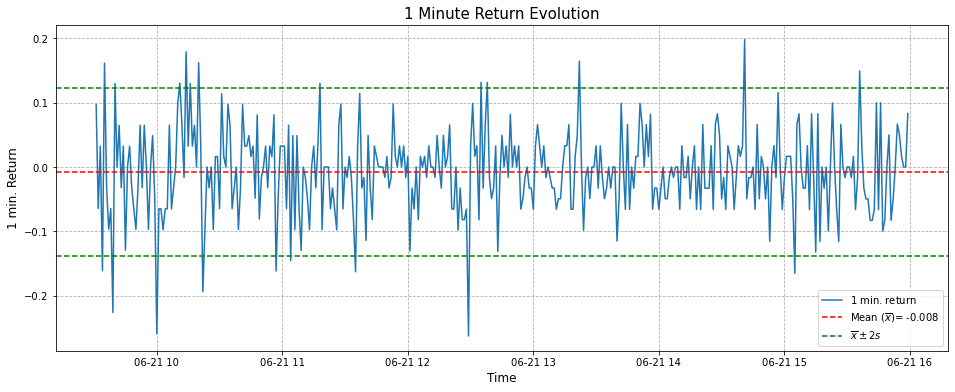

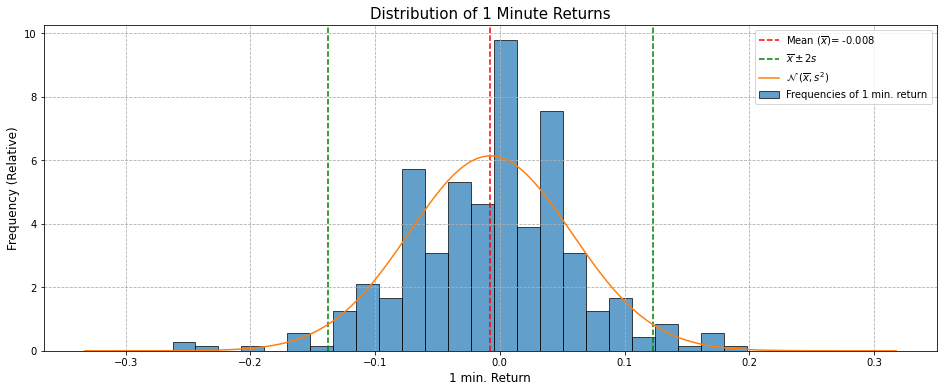

In [11]:
# normal distribution pdf
def normal_pdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / (sigma))**2) / (sigma * np.sqrt(2 * np.pi))

# sample statistics
mean = MSFT_trades_1min_df['Return'].mean()                                                     
stddev = MSFT_trades_1min_df['Return'].std()

# z-score bound -> to define 'extreme' moves, returns outside 2 std dev of sample mean
z_bound = 2

# 1 min returns plot
plt.figure(figsize = (16, 6))                                
plt.plot(MSFT_trades_1min_df['Return'], label = '$1$ min. return')
plt.xlabel('Time', size = 12)
plt.ylabel('1 min. Return', size = 12)
plt.title('1 Minute Return Evolution', size = 15)
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean ($\overline{x}$)' + f'= {mean:.3f}')
plt.axhline(mean + z_bound * stddev, color = 'g', linestyle = '--', label = '$\overline{x}' + f' \pm {z_bound}s$')    # bounds
plt.axhline(mean - z_bound * stddev, color = 'g', linestyle = '--')
plt.grid(True, linestyle = '--')
plt.legend()

# 1 min return histogram
plt.figure(figsize = (16, 6))                                
plt.hist(MSFT_trades_1min_df['Return'], density = True, bins = 25, alpha = 0.7, edgecolor = 'k', label = 'Frequencies of 1 min. return')
plt.xlabel('1 min. Return', size = 12)
plt.ylabel('Frequency (Relative)', size = 12)
plt.title('Distribution of 1 Minute Returns', size = 15)
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean ($\overline{x}$)' + f'= {mean:.3f}')             
plt.axvline(mean + z_bound * stddev, color = 'g', linestyle = '--', label = '$\overline{x}' + f' \pm {z_bound}s$')    # bounds
plt.axvline(mean - z_bound * stddev, color = 'g', linestyle = '--')
x = np.linspace(mean - 5 * stddev, mean + 5 * stddev, 1000)                                       
plt.plot(x, normal_pdf(x, mean, stddev), label = '$\mathcal{N}\ (\overline{x}, s^{2})$')                              # normal curve
plt.grid(True, linestyle = '--')
plt.legend();

The $1$ minute returns for `MSFT` do not seem to be `Normally distibuted` as the distribution of returns is **peaked** and **fat-tailed**. One can run a `Jarque-Bera` test to evaulate the normality of returns using `SciPy` library.

##### `Bid-Ask Spread`

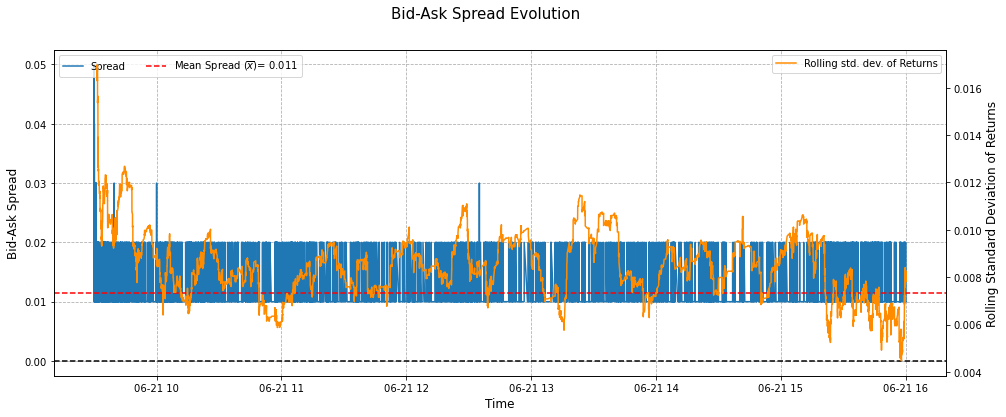

In [12]:
# mean spread
mean = MSFT_trades_df['Bid Ask Spread'].mean() 

# plot figure
fig, ax1 = plt.subplots(1, figsize = (16, 6))
fig.suptitle('Bid-Ask Spread Evolution', size = 15)
ax1_1 = ax1.twinx()

# spread plot
ax1.set_xlabel('Time', size = 12)
ax1.set_ylabel('Bid-Ask Spread', size = 12)
ax1.grid(True, linestyle = '--')
ax1.plot(MSFT_trades_df['Bid Ask Spread'], label = 'Spread')
ax1.axhline(mean, color = 'r', linestyle = '--', label = 'Mean Spread ($\overline{x}$)' + f'= {mean:.3f}')
ax1.axhline(0, color = 'k', linestyle = '--')
ax1.legend(loc = 2, ncol = 2)

# rolling standard deviation of returns plot
ax1_1.plot(MSFT_trades_df['Return'].rolling(window = 500).std(), color = 'darkorange', label = 'Rolling std. dev. of Returns')
ax1_1.legend(loc = 1)
ax1_1.set_ylabel('Rolling Standard Deviation of Returns', size = 12);

Visually, it seems that higher `bid-ask spreads` are associated with higher `volatility` (_variation_) in returns.

##### `Depth of Market Evolution`

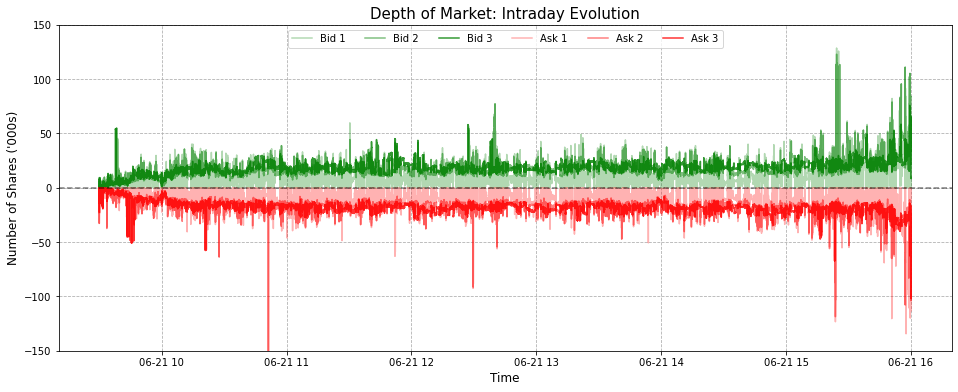

In [13]:
plt.figure(figsize = (16, 6))

# plot bid sizes
plt.plot(MSFT_orderbook_df['Bid Size 1'] / 10**3, color = 'g', alpha = 0.3, label = 'Bid 1')
plt.plot(MSFT_orderbook_df['Bid Size 2'] / 10**3, color = 'g', alpha = 0.5, label = 'Bid 2')
plt.plot(MSFT_orderbook_df['Bid Size 3'] / 10**3, color = 'g', alpha = 0.8, label = 'Bid 3')

# plot ask sizes
plt.plot(-MSFT_orderbook_df['Ask Size 1'] / 10**3, color = 'r', alpha = 0.3, label = 'Ask 1')
plt.plot(-MSFT_orderbook_df['Ask Size 2'] / 10**3, color = 'r', alpha = 0.5, label = 'Ask 2')
plt.plot(-MSFT_orderbook_df['Ask Size 3'] / 10**3, color = 'r', alpha = 0.8, label = 'Ask 3')

plt.axhline(0, color = 'k', alpha = 0.5, linestyle = '--')

plt.xlabel("Time", size = 12)
plt.ylabel("Number of Shares ('000s)", size = 12)
plt.title("Depth of Market: Intraday Evolution", size = 15)
plt.grid(True, linestyle = '--')
plt.ylim([-150, 150])

plt.legend(ncol = 6, loc = 9);

The `limit order book` for `MSFT` seems to be liquid (_at least visually_) as the depth (_number of shares_) on both the sides (_buy / sell_) is "large".

##### `Limit Order Book Snapshot`

Let's have a look at orderbook at $11$ am.

In [14]:
time = '110000'    # HHMMSS

In [15]:
mask_snap = MSFT_orderbook_df.index < pd.Timestamp(f'{date}{time}')     
snap = MSFT_orderbook_df.loc[mask_snap].iloc[-1:]                       # last row before time
snap

,Ask Price 1,Ask Size 1,Bid Price 1,Bid Size 1,Ask Price 2,Ask Size 2,Bid Price 2,Bid Size 2,Ask Price 3,Ask Size 3,Bid Price 3,Bid Size 3,Ask Price 4,Ask Size 4,Bid Price 4,Bid Size 4,Ask Price 5,Ask Size 5,Bid Price 5,Bid Size 5
Time,,,,,,,,,,,,,,,,,,,,
2012-06-21 10:59:59.603025222,30.9,12230,30.89,7300,30.91,16421,30.88,11884,30.92,18124,30.87,19167,30.93,16109,30.86,22791,30.94,16156,30.85,17819


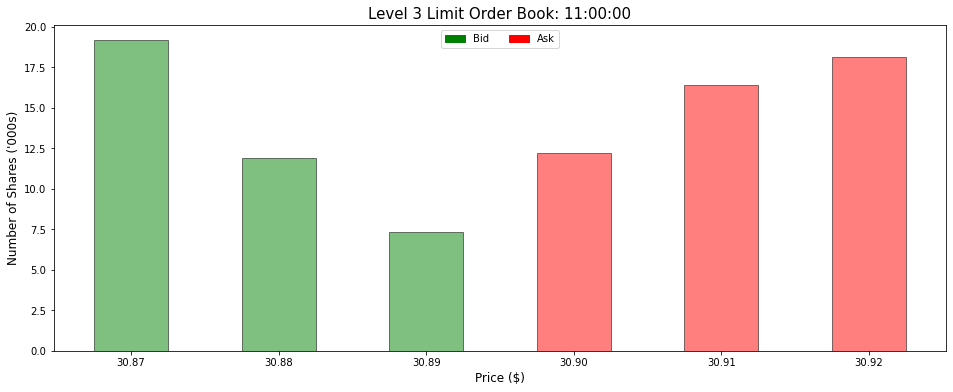

In [16]:
plt.figure(figsize = (16,6))

# x and y values of bar plot
x = [snap['Bid Price 3'].values[0], snap['Bid Price 2'].values[0], snap['Bid Price 1'].values[0], 
     snap['Ask Price 1'].values[0], snap['Ask Price 2'].values[0], snap['Ask Price 3'].values[0]]
y = [snap['Bid Size 3'].values[0] / 10**3, snap['Bid Size 2'].values[0] / 10**3, snap['Bid Size 1'].values[0] / 10**3, 
     snap['Ask Size 1'].values[0] / 10**3, snap['Ask Size 2'].values[0] / 10**3, snap['Ask Size 3'].values[0] / 10**3]

# bar plot
plt.xlabel("Price ($)", size = 12)
plt.ylabel("Number of Shares ('000s)", size = 12)
plt.title("Level 3 Limit Order Book: 11:00:00", size = 15)

plt.bar(x, y, width = 0.005, color = ['g', 'g', 'g', 'r', 'r', 'r'], alpha = 0.5, edgecolor = 'k')

# getting legend right for bar plot
colors = {'Bid':'green', 'Ask':'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color = colors[label]) for label in labels]
plt.legend(handles, labels, loc = 9, ncol = 2);

The top $3$ levels of `MSFT` limit order book at $11$ am is slightly skewed towards `Ask` indicating a selling pressure.

##### `Volume Order Imbalance` summary

In [17]:
MSFT_trades_df['VOI'].describe().to_frame()

,VOI
count,33414.000000
mean,-0.020449
std,0.650727
min,-0.999882
25%,-0.629421
50%,-0.061186
75%,0.618365
max,0.999805


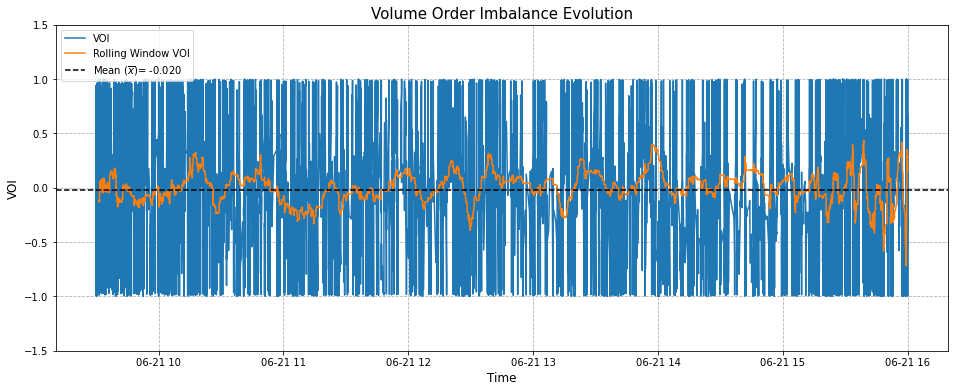

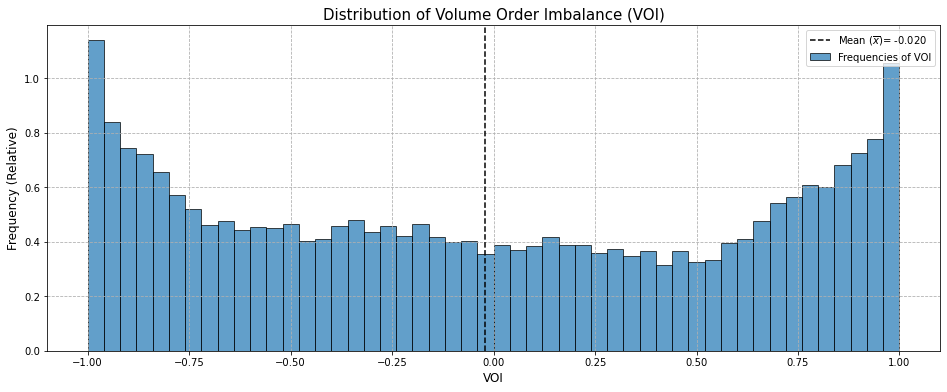

In [18]:
# mean VOI
mean = MSFT_trades_df['VOI'].mean()                                                     

# VOI plot
plt.figure(figsize = (16, 6))                                
plt.plot(MSFT_trades_df['VOI'], label = 'VOI')
plt.plot(MSFT_trades_df['VOI'].rolling(window = 500).mean(), label = 'Rolling Window VOI')
plt.xlabel('Time', size = 12)
plt.ylabel('VOI', size = 12)
plt.title('Volume Order Imbalance Evolution', size = 15)
plt.axhline(mean, color = 'k', linestyle = '--', label = 'Mean ($\overline{x}$)' + f'= {mean:.3f}')
plt.grid(True, linestyle = '--')
plt.ylim([-1.5, 1.5])
plt.legend()

# histogram of VOI
plt.figure(figsize = (16, 6))
plt.hist(MSFT_trades_df['VOI'], density = True, bins = 50, alpha = 0.7, edgecolor = 'k', label = 'Frequencies of VOI')
plt.xlabel('VOI', size = 12)
plt.ylabel('Frequency (Relative)', size = 12)
plt.title('Distribution of Volume Order Imbalance (VOI)', size = 15)
plt.axvline(mean, color = 'k', linestyle = '--', label = 'Mean ($\overline{x}$)' + f'= {mean:.3f}')             
plt.grid(True, linestyle = '--')
plt.legend();

<a id='sec3'></a>
## 3. `Relationship between VOI and Returns`
---
Here we will research and find out whether there is a significant relationship between **`volume order imbalance`** (VOI) and **`Returns`** using some simple tools like **`correlation analysis`** and **`linear regression`**.

**_Note:_** We will only analyze the top level VOI.

First, let's `resample` the trades data to `100ms` as it is a standard practice to compute metrics over a fixed time window for consistency sake. We will also remove rows with $0$ returns as we are generally trade when price changes.

In [19]:
MSFT_trades_100ms_df = MSFT_trades_df.resample('100ms').median().dropna()                                         # resample
MSFT_trades_100ms_df['VOI'] = (MSFT_trades_100ms_df['Bid Size 1'] - MSFT_trades_100ms_df['Ask Size 1']) \
                              / (MSFT_trades_100ms_df['Bid Size 1'] + MSFT_trades_100ms_df['Ask Size 1'])       # resampled VOI
                              
MSFT_trades_100ms_df['Return'] = np.log(MSFT_trades_100ms_df['Price']).diff() * 100                             # resampled return

mask_non_zero_returns = MSFT_trades_100ms_df['Return'] != 0                                                     # non-zero return mask
MSFT_trades_100ms_df = MSFT_trades_100ms_df.loc[mask_non_zero_returns]

##### `Visual Correlation` via scatter plot

In [20]:
x = MSFT_trades_100ms_df['VOI'][1:]
y = MSFT_trades_100ms_df['Return'][1:]

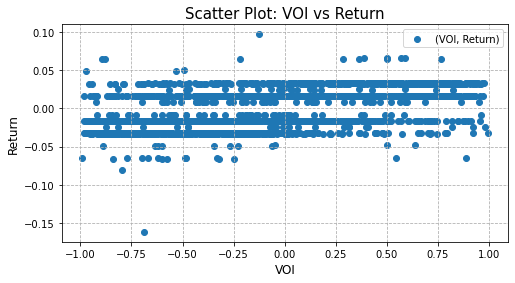

In [21]:
plt.figure(figsize = (8, 4))

# scatter plot
plt.scatter(x, y, label = '(VOI, Return)')
plt.xlabel('VOI', size = 12)
plt.ylabel('Return', size = 12)
plt.title('Scatter Plot: VOI vs Return', size = 15)
plt.grid(True, linestyle = '--')
plt.legend();

Its bit difficult to tell visually if `significant correlation` exists. Let's use `scipy.stats` to calculate **`pearson correlation`** and evaluate its significance.

##### `Pearson correlation`

In [22]:
corr, p_val = pearsonr(x, y)
print(f'=======Correlation b/w VOI and Return=======')
print(f'Correlation: {corr:.3f}')
print(f'P-value: {p_val:.3f}')
print(f'============================================')

=======Correlation b/w VOI and Return=======
Correlation: 0.544
P-value: 0.000


We see a mild to strong positive relationship between `VOI` and `Return` and it also turns out to be **significant**.

##### `Linear Regression (OLS)`

In [23]:
ols = sm.OLS(y, sm.add_constant(x), missing = 'drop').fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     939.1
Date:                Mon, 22 Aug 2022   Prob (F-statistic):          1.88e-172
Time:                        18:01:40   Log-Likelihood:                 5344.1
No. Observations:                2235   AIC:                        -1.068e+04
Df Residuals:                    2233   BIC:                        -1.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.326      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Key observations from the OLS:
- `VOI` has a positive coefficient which is very significant.
- We have a "decent" R-squared value of $0.296$ indicating that `VOI` can be predictor of future `Returns`.

<a id='sec4'></a>
## 4. `Trading Signal / Strategy`
---

A (_naive_) trading strategy can be `long` or `short` our `MSFT` stock given the current value of `VOI`. This means if our model were to predict a positive return for the future, we would immediately buy the stock and then close out our position at next `price` change to produce a return.

Given the positive `correlation` between `VOI` and `Return` - a positive VOI would imply positive return (price gain) in future and vice-versa.

##### Setup `strategy_df` by getting `VOI` and `Price` columns

In [24]:
strategy_df = pd.concat([MSFT_trades_100ms_df['VOI'], MSFT_trades_100ms_df['Price']], axis = 'columns')
strategy_df

,VOI,Price
Time,,
2012-06-21 09:30:00.000,-0.853229,30.9650
2012-06-21 09:30:00.300,0.285714,30.9850
2012-06-21 09:30:00.600,-0.970532,31.0000
2012-06-21 09:30:00.900,-0.968442,30.9900
2012-06-21 09:30:01.000,-0.790200,31.0000
...,...,...
2012-06-21 15:59:59.000,0.521492,30.1375
2012-06-21 15:59:59.200,0.589955,30.1400
2012-06-21 15:59:59.400,0.602659,30.1350


##### `Strategy code`

In [25]:
"""
Strategy code explanation: 

numpy select
... if condition is true i.e. 1st positional argument
... calculate the choice i.e. 2nd positional argument
... else calculate default i.e. 3rd positional argument

condlist -> if VOI is positive
choicelist -> buy at current price and sell at next price
default (when VOI is negative) -> short at current price and cover at next price
""" 

profit = np.select(condlist = [strategy_df['VOI'] > 0], 
                   choicelist = [strategy_df['Price'].shift(-1) - strategy_df['Price']], 
                   default = strategy_df['Price'] - strategy_df['Price'].shift(-1))

profit = profit[~np.isnan(profit)]     # remove nans through boolean mask
profit

array([-0.02 ,  0.015,  0.01 , ..., -0.005, -0.005,  0.005])

##### `Strategy PnL plot`

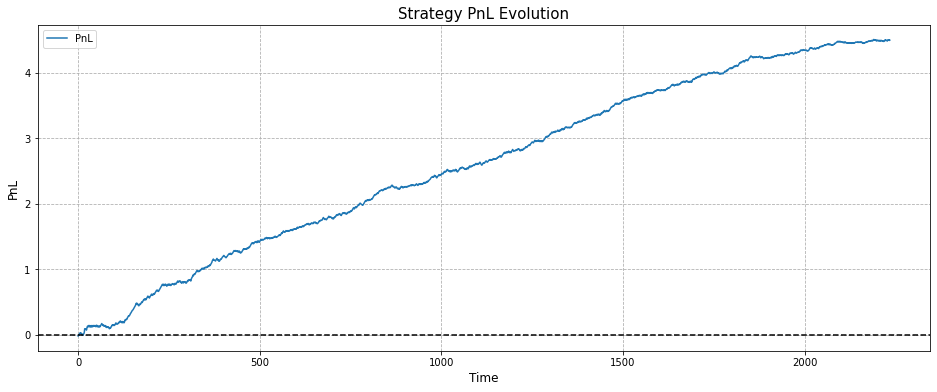

In [26]:
plt.figure(figsize = (16, 6))

plt.plot(profit.cumsum(), label = 'PnL')
plt.axhline(0, color = 'k', linestyle = '--')
plt.xlabel('Time', size = 12)
plt.ylabel('PnL', size = 12)
plt.title('Strategy PnL Evolution', size = 15)
plt.grid(True, linestyle = '--')
plt.legend();

Visually, the strategy seems to be doing good. Now let's calculate some statistics to evaluate the strategy numerically.

##### `Strategy Evaluation`

In [27]:
num_trades = len(profit)
mean_profit = profit.mean()
stddev_profit = profit.std()
sharpe = mean_profit / stddev_profit
ratio_win_trades = 100 * sum(profit > 0) / num_trades

print(f'======Strategy Evaluation======', '\n')
print(f'Number of trades: {num_trades}')
print(f'Avg. profit per trade: {mean_profit:.4f}')
print(f'Sharpe: {sharpe:.2f}')
print(f'Ratio of winning trades: {ratio_win_trades:.1f}%')
print(f'===============================')

======Strategy Evaluation====== 

Number of trades: 2235
Avg. profit per trade: 0.0020
Sharpe: 0.26
Ratio of winning trades: 61.2%


Our strategy has a `sharpe ratio` of $0.26$ is not good enough. At the very minimum, we would like a value of $1$, i.e. that your average return is greater than the variance in returns, otherwise we are just looking at noise.

How many times did we correctly guess the direction of the market though? This is the `hit ratio` of the strategy, which in our case is $61\%$. It is better than a coin toss ($50\%$), which is good and shows there is a little bit of information in the `VOI` values when predicting future returns.

<a id='conc'></a>
## `Conclusion`
---

##### `Relationship between VOI and Returns`
We see that the relationship between `Volume Order Imbalance` (VOI) and future `Returns` is signifincant when evaluated through `correlation analysis` and `linear regression`. `VOI` can be a useful signal to predict future `Price` movement with general pattern being positive VOI leading to higher price movements and vice-versa.

###### Limitations:
- We did not check assumptions like `normality`, no `auto-correlation` etc. on our data before making inference
- We did this analysis only on `MSFT` and for only one trading day. Ideally, one should test this analysis on multiple instruments and over multiple time periods

##### `Signal / Strategy using VOI`
At the first glance, the `VOI` signal looks like a profitable strategy. But this may not be true in practice.

###### Limitations:
- We have not accounted for trading costs (_like `bid-ask spread`, transaction charges, etc._) which may be significant for `high frequency trading`
- The `Sharpe ratio` is not good enough. With a Sharpe ratio $< 1$ shows that there is not much actual information in the trading pattern
- The strategy is trained on a tiny amount of data (_only MSFT and that too only one trading day_)
- We need high performance `C / C++` code instead of `Python` and superior trading infrastructure (_e.g. `co-located servers`, fast internet etc._)
... and many other limitations that I might have missed.

##### `Possible usefulness`
This insight on relationship between `VOI` and predictability of future price movement may be useful in some cases.

###### For Market Makers
Making markets is about posting quotes where they will get filled and collecting the `bid-ask spread`. Therefore, as `VOI` seems to be able to predict the direction of `Price`, we could use it to place a quote where the market will be in one second, rather than where it is now. This helps put our quote at the top of the queue if the market (_`Queue-Time Priority`_) does move in that direction.

---